# ETE ML Regression Project

## Purpose 
This workbook is used as a walk-through template of a typical ML project. This follows the process shown in chapter2 of the book - handson ml with sklearn and tf. Original github repo can be found [here](https://github.com/ageron/handson-ml).<br/>

I have added into this notebook my understanding on each section and also correction to a couple original codes as sklearn has changed a little bit since the book was released. A few exceptions will be raised if we only follow the original codes from the github repo.

## Before the project even begins...
### 1. Frame the problem and look at the big picture.
**ask your boss what exactly is the business objective; How does the company expect to use and benefit from this model?**

Why: this determines how you frame the problem, what algorithms you will select, what performance measure you will use to evaluate your model, and how much effort you should spend tweaking it. In many cases, your model is one component of a whole decision making process, it’s important to make a good data pipeline.

**what the current solution looks like? E.g. prices are currently estimated manually by experts: a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules.** 

Why: this will give us a benchmark performance and insights on how to solve the problem. Problem with current approach: costly, inaccurate...
If we need to deal with large data, we can consider splitting data into mini batches and use mapreduce (or online learning technique)

### 2. Performance measures
Norm measures are used to determine performance (RMSE, MAE) comparing y-hat and y, RMSE more sensitive to outliers, does well with bell-shaped data

### 3. Always check assumptions used

### 4. Get the data
Data can be stored in a database or hosted on the internet. To get data from a database, please check here. For the latter case, please read on. We will automate the process in the next cell.

In [1]:
# Create a function to always download the latest data from github
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
# download the data and save it in the datasets folder
fetch_housing_data()

initial run resulted in exceptionSSL: CERTIFICATE_VERIFY_FAILED
solved it with this [solution](https://stackoverflow.com/questions/51774807/airbrake-error-urlopen-error-ssl-certificate-verify-failed-certificate-verif)


In [3]:
# load the data with pandas
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## 5. Quick look at our data

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Findings are: missing data for "total_bedrooms", object data for ocean_proximity (since it's coming from csv, it must be text data)

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


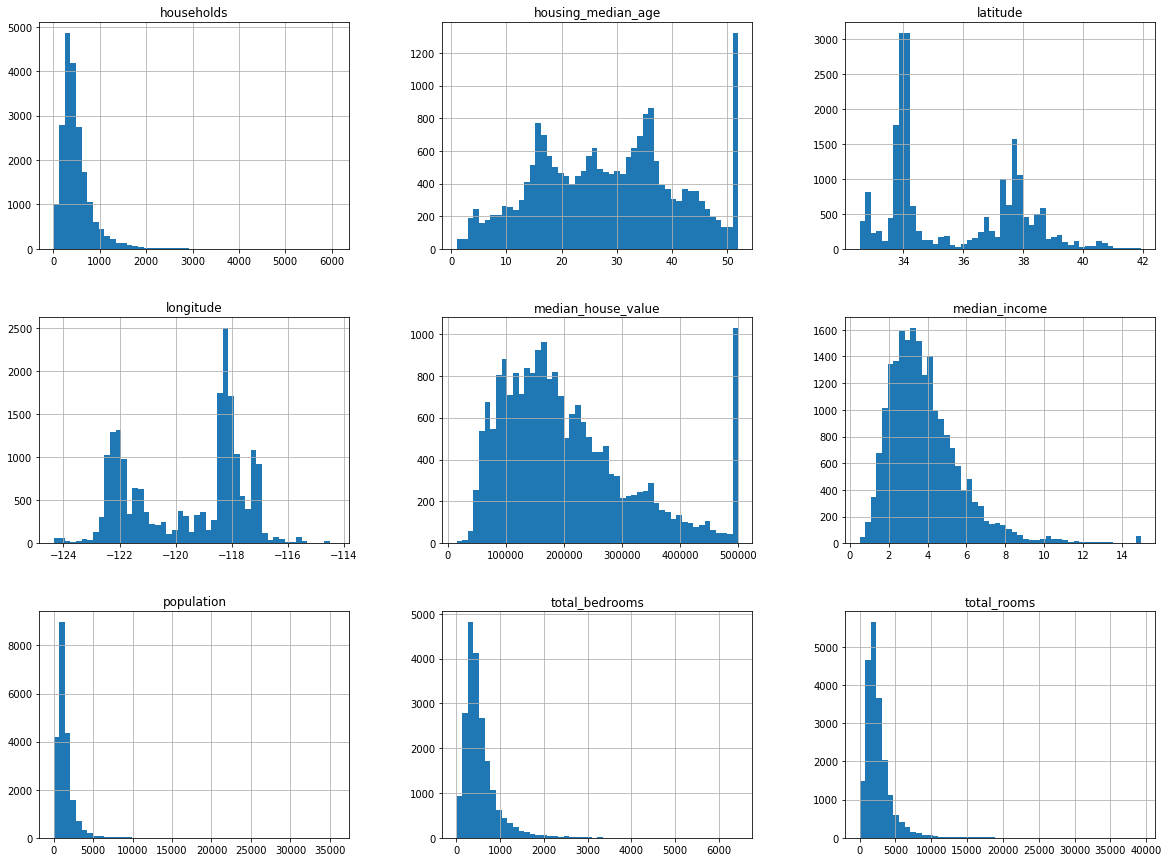

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

**Findings are:**
1. housing_median_age and housing_median_value are capped: lots of data are at the high end, this needs to be **checked with the right team from the business.**
2. variables have different scales, **feature scaling might be needed**
3. long tails observed in many variables, **transformation required**

In [31]:

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('housing_with_id', 3159364),
 ('housing', 2994244),
 ('train_set', 2395315),
 ('strat_train_set', 2395258),
 ('set_', 598930),
 ('strat_test_set', 598930),
 ('test_set', 598873),
 ('train_index', 132192),
 ('test_index', 33120),
 ('StratifiedShuffleSplit', 1056),
 ('HOUSING_URL', 136),
 ('checkMemory', 136),
 ('fetch_housing_data', 136),
 ('load_housing_data', 136),
 ('split_train_test_by_id', 136),
 ('test_set_check', 136),
 ('train_test_split', 136),
 ('DOWNLOAD_ROOT', 108),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('HOUSING_PATH', 65),
 ('split', 56)]

In [30]:
checkMemory()

[]


## 6. Create a test set
Now is a good time to create a test set and put it aside. We won't look at this dataset to avoid data snooping bias.
Ways to create train test split:
1. sklearn's train_test_split (set a random state for reproducibility purpose)
2. custom function similar to above method based on random split
3. custom function with hash

In [10]:
# custom function with hash
import hashlib
import numpy as np
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[-in_test_set], data.loc[in_test_set]

In [11]:
# method 1: use row id as unique identifier
# we need to make sure new data only get appended
# to end of original df and no row ever gets deleted
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
# method 2: create a new identifier with most stable data
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# multiple datasets can be potentially passed into train_test_split given same length

### Other factors to consider
Sometimes, random sampling is not enough as we need to make sure our test set is representative of the population (needs to ensure similar distribution for important attributes). **Stratified Sampling**

In [14]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)
# pd.series.where(con, other) will do nothing if con is met, otherwise replace with other

In [15]:
# StratifiedShuffleSplit from sklearn will make sure income_cat in test set is representative of total dataset
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [32]:

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('housing_with_id', 3159364),
 ('housing', 2994244),
 ('train_set', 2395315),
 ('strat_train_set', 2395258),
 ('set_', 598930),
 ('strat_test_set', 598930),
 ('test_set', 598873),
 ('train_index', 132192),
 ('test_index', 33120),
 ('StratifiedShuffleSplit', 1056),
 ('HOUSING_URL', 136),
 ('checkMemory', 136),
 ('fetch_housing_data', 136),
 ('load_housing_data', 136),
 ('split_train_test_by_id', 136),
 ('test_set_check', 136),
 ('train_test_split', 136),
 ('DOWNLOAD_ROOT', 108),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('HOUSING_PATH', 65),
 ('split', 56)]

## 7. Exploratory Data Analysis
**The purpose of EDA is to make patterns stand out**

In [33]:
# make a copy of training dataset
housing = strat_train_set.copy()

### Visualising geographical data

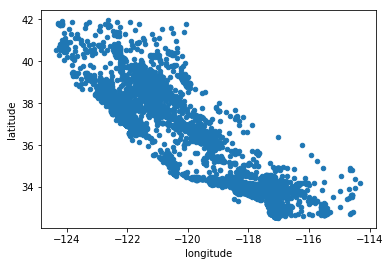

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Below is a map of Califonia (source: google maps), just to give us some reference of the scatter plot

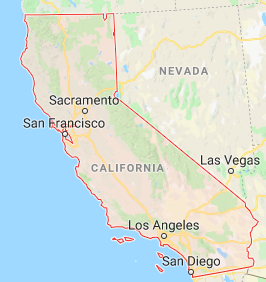

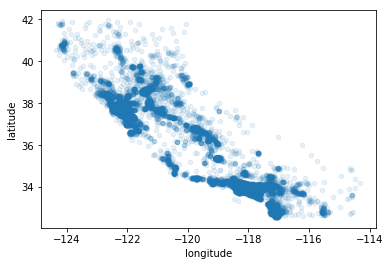

In [35]:
# to make this graph clearer as we want to see density of points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

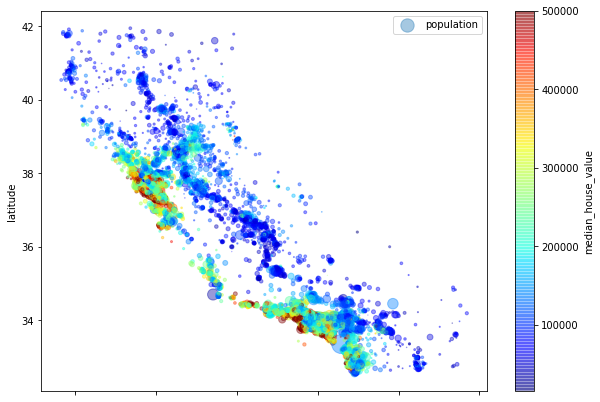

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

Findings are:
housing price (colorful dots) are probably related to
1. distance to ocean
2. population

### Correlation Viz (linear and non-linear)

In [37]:
# linear correlation
corr_matrix = housing.corr()

In [38]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

/Users/norman/handson-ml/handson-ml-implementation/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11476e6d8>,
      dtype=object)

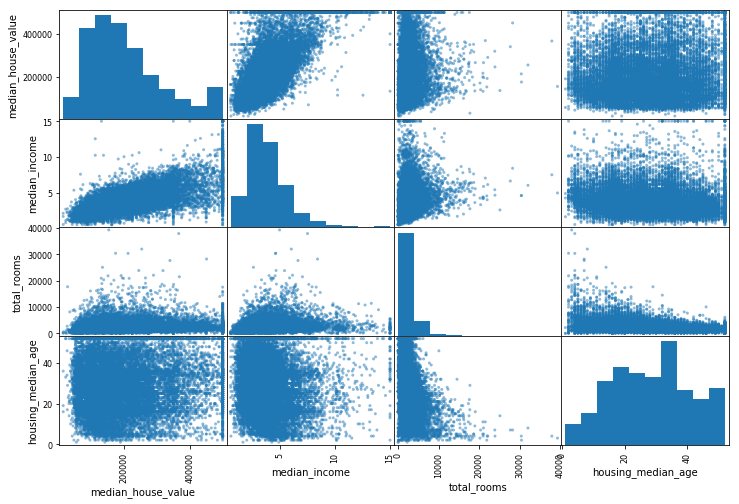

In [39]:
# scatter_matrix from pandas is useful to generate pairwise graphs
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

In [40]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [41]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## 8. Preprocessing (make data ready for modelling)
Steps should cover:
1. split features, label/s from training dataset;
2. data cleaning (na)

In [42]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Missing value
Options are:
1. remove rows
2. remove cols
3. imputation with some value

In [43]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [44]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [45]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [46]:
# this is where the impute value was saved (for all cols)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [47]:
X = imputer.transform(housing_num)

### Categorical Feature Handling
Why: most ml model prefer to work with numbers <br/>
sklearn's labelencoder can first fit and transform (or just use fit_transform method) categorical column into numerical equivalent

In [48]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [49]:
print(encoder.classes_)
print(encoder.transform(encoder.classes_))
print(encoder.inverse_transform(encoder.transform(encoder.classes_)))

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
[0 1 2 3 4]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


problems with this encoding: this encoding implies "1h ocean" is closee to "inland" than "island" or "near ocean". OneHotEncoder is more appropriate.

In [50]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

/Users/norman/handson-ml/handson-ml-implementation/env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

From the warning message, we can apply OneHotEncoder straightway to our categorical data without running LabelEncoder in the future <br/>
Output is saved in a scipy sparse matrix, this format saved memory usage as it only stores position of "1"s of a sparse matrix

In [51]:
print("OneHotEncoder applied on LabelEncoded data:")
housing_cat_1hot

OneHotEncoder applied on LabelEncoded data:


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [52]:
print("OneHotEncoder applied on raw data straightaway:")
encoder.fit_transform(housing_cat.values.reshape(-1,1))

OneHotEncoder applied on raw data straightaway:


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [53]:
print("LabelBinarizer applied on raw data straightaway:")
binarizer = LabelBinarizer()
binarizer.fit_transform(housing_cat.values.reshape(-1,1))

LabelBinarizer applied on raw data straightaway:


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

OneHotEncoder.fit_transform expects 2d array, that's why we performed the 1d array.reshape(-1, 1). <br/>
The "-1" means numpy will figure out the shape for dim1 automatically

### Custom Tranformers
This is an important section as in many cases, we need to be able to generate custom transformer class so we can tackle different data accordingly and make our work automatic and reproducible. Below can be used as a template for future use. <br/>
To make sure our custom transformer work seamlessly with sklearn's functionalities (pipeline, etc), we need to make sure necessary methods(fit, transform, fit_transform) are available in our custom class.<br/>
When create our custom class (i.e. transformer, estimator), we can add **BaseEstimator** and **TransformerMixin** as base classes. The former one gives us get_params() and set_params() methods and the latter gives us fit_transform() method for free.

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # make sure no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, household_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

In [55]:
# transform np.array of original df
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [56]:
# output result
housing_extra_attribs[0]

array([-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
       '<1H OCEAN', 4.625368731563422, 2.094395280235988], dtype=object)

In [57]:
# compare with input data
# there are a few new cols after "1h ocean"
housing.values[0]

array([-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
       '<1H OCEAN'], dtype=object)

### Feature Scaling
**Why**: ml algorithms don't perform well when the input numerical attributes have very different scales <br/>
**Common Options**: min-max scaling and standization <br/>
**Note**: always only fit transfomer (scaler in this case) with training data and then apply transform method on both training and test

### Transformation Pipeline

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

**Note**: Imputer is now called SimpleImputer from sklearn

sklearn estimators work only on numpy arrays. Instead of manually converting pd.df to np.array (by using df\[cols\].values. We can create a class to do this automatically. This can then be included into a sklearn.pipeline

In [59]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values

In [ ]:
from sklearn.ensemble import RandomForestRegressor

feature_importances = grid_search.best_estimator_.feature_importances_

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        return self
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        forest_reg = RandomForestRegressor()
        forest_reg.fit()
        
        

In [60]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [61]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('one_hot_encoder', OneHotEncoder(sparse=False)),
])

From original handson ml book, LabelBinarizer was used as the second step in above cat_pipeline, however, since its fit_transform only takes two positional argument, see [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer.fit_transform), this will cause a problem when we run the fit_transform method on the full_pipeline as any other transfomers have a 3 positional args. As a result, OneHotEncoder is used instead, see [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.fit_transform) for more details. When I search internet, I found this question is already on stackoverflow, so I contributed my findings to this [question](https://stackoverflow.com/questions/46162855/fit-transform-takes-2-positional-arguments-but-3-were-given-with-labelbinarize) as well :). 

In [62]:
# Make a complete pipeline by joining the two pipelines using FeatureUnion
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [63]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

In [64]:

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('housing_with_id', 3907764),
 ('train_set', 2993951),
 ('strat_train_set', 2993666),
 ('housing', 2861570),
 ('housing_prepared', 2113648),
 ('housing_cat', 1804802),
 ('housing_extra_attribs', 1453168),
 ('housing_num_tr', 1453168),
 ('housing_num', 1188888),
 ('X', 1056880),
 ('set_', 748922),
 ('strat_test_set', 748922),
 ('test_set', 748637),
 ('housing_cat_1hot', 660592),
 ('housing_labels', 264216),
 ('housing_cat_encoded', 132192),
 ('train_index', 132192),
 ('test_index', 33120),
 ('corr_matrix', 2511),
 ('LabelBinarizer', 1184),
 ('SimpleImputer', 1184),
 ('StandardScaler', 1184),
 ('BaseEstimator', 1056),
 ('CombinedAttributesAdder', 1056),
 ('DataFrameSelector', 1056),
 ('FeatureUnion', 1056),
 ('LabelEncoder', 1056),
 ('Pipeline', 1056),
 ('StratifiedShuffleSplit', 1056),
 ('TransformerMixin', 1056),
 ('OneHotEncoder', 888),
 ('num_attribs', 160),
 ('HOUSING_URL', 136),
 ('checkMemory', 136),
 ('fetch_housing_data', 136),
 ('load_housing_data', 136),
 ('scatter_matrix', 1

In [65]:
del housing_with_id
del train_set
del strat_train_set

## 9. Modelling... Finally...

Now since we have a well prepared dataset. We can start our modelling work (the exciting part). 

The general process is:
1. fit several models on the training dataset (before spending too much time tweaking their hyperparameters)
2. use cross validation to generate prediction scores on both training and validation set
3. shortlist a few more promising models (two to five)
4. fine tune these models hyperparameters (e.g. grid-search, randomized search)
5. ensemble models
6. improve features selection
7. evaluate result on test set

### Fit several models (for example)

In [66]:
# linear regressor
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [67]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [68]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

/Users/norman/handson-ml/handson-ml-implementation/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
from sklearn.svm import SVR
svm_reg = SVR(gamma = 'scale')
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [72]:

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:10]

[('housing', 2861570),
 ('housing_prepared', 2113648),
 ('housing_cat', 1804802),
 ('housing_extra_attribs', 1453168),
 ('housing_num_tr', 1453168),
 ('housing_num', 1188888),
 ('X', 1056880),
 ('set_', 748922),
 ('strat_test_set', 748922),
 ('test_set', 748637)]

### Cross Validation

In [73]:
# !pip install PrettyTable
from prettytable import PrettyTable
# I wrote a small funciton to display training and cross validation scores for a series of models
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


def display_scores(models, model_names, X, y, cv=10, score='rmse'):
    """
    this function will display both training and validation score for a series of models
    models: list of models, 
    X: np array of training_set_features, 
    y: np array of training_set_labels
    score: string that specifies performance score
    at the moment, it's only displaying scores for 'rmse', will extend this function more types later
    """
    
    t = PrettyTable(['Models', 'Training_'+score.upper(), 'Validation_'+score.upper()])
    
    if score == 'rmse':
        for i in range(len(models)):
            # get the training score
            predictions = models[i].predict(X)
            training_mse = mean_squared_error(y, predictions)
            training_rmse = np.sqrt(training_mse)
            # get the validation score
            val_mse = -cross_val_score(models[i], X, y,
                            scoring="neg_mean_squared_error", cv=cv).mean()
            val_rmse = np.sqrt(val_mse)
            # insert data into final table
            t.add_row([model_names[i], training_rmse, val_rmse])
            
    print(t)

In [74]:
models = [lin_reg, tree_reg, forest_reg, svm_reg]
model_names = ['lin_reg', 'tree_reg', 'forest_reg', 'svm_reg']
display_scores(models, model_names, X=housing_prepared, y=housing_labels)

+------------+--------------------+--------------------+
|   Models   |   Training_RMSE    |  Validation_RMSE   |
+------------+--------------------+--------------------+
|  lin_reg   | 68911.49637588045  | 69357.96864528397  |
|  tree_reg  |        0.0         | 71365.77917476601  |
| forest_reg | 22257.62415555681  | 53004.12070883837  |
|  svm_reg   | 118576.84511478753 | 118614.37923055777 |
+------------+--------------------+--------------------+


**Intepretation of our result**

Most districts’ median_housing_values range between 120,000 and 265,000, so a typical prediction error of 50,000 to 70,000 is not very satisfying. When training error is high, our model is underfitting. When validation error is high (higher than training error), our model is overfitting. To treat underfitting, we can increase model complexity. To treat overfitting, we can use: 1) regularisation; 2) simplify model; 3) get more data

### Fine tune our model - hyperparameter tuning

### Random Search vs Grid Search - Random Forest

In [75]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [76]:
from sklearn.metrics import make_scorer
def rmse(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [79]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [ 30, 50], 'max_features': [2, 4, 8],
 'min_samples_split': [2, 6, 10],'bootstrap': [True, False]}]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring=rmse_scorer)

In [80]:
from time import time 
start = time()
grid_search.fit(housing_prepared, housing_labels)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 338.31 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: -48730.007 (std: 1205.238)
Parameters: {'bootstrap': False, 'max_features': 8, 'min_samples_split': 6, 'n_estimators': 50}

Model with rank: 2
Mean validation score: -48779.580 (std: 1043.708)
Parameters: {'bootstrap': False, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 50}

Model with rank: 3
Mean validation score: -48874.837 (std: 1295.287)
Parameters: {'bootstrap': False, 'max_features': 4, 'min_samples_split': 2, 'n_estimators': 50}



In [81]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# RandomizedSearchCV
# specify parameters and distributions to sample from
param_dist = {
              "n_estimators": sp_randint(3, 50),
              "max_features": sp_randint(2, 9),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False]}
n_iter_search = 50
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, 
                                   scoring=rmse_scorer)

In [82]:
start = time()
random_search.fit(housing_prepared, housing_labels)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 322.98 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: -48326.526 (std: 1161.867)
Parameters: {'bootstrap': False, 'max_features': 5, 'min_samples_split': 8, 'n_estimators': 45}

Model with rank: 2
Mean validation score: -48606.699 (std: 1260.577)
Parameters: {'bootstrap': False, 'max_features': 6, 'min_samples_split': 7, 'n_estimators': 41}

Model with rank: 3
Mean validation score: -48796.003 (std: 1033.407)
Parameters: {'bootstrap': False, 'max_features': 7, 'min_samples_split': 4, 'n_estimators': 43}



In [83]:
random_search.best_estimator_.fit(housing_prepared, housing_labels)
grid_search.best_estimator_.fit(housing_prepared, housing_labels)
forest_reg.fit(housing_prepared, housing_labels)

/Users/norman/handson-ml/handson-ml-implementation/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
models = [random_search.best_estimator_, grid_search.best_estimator_, forest_reg]
model_names = ['random_search_forest', 'grid_search_forest', 'original_forest']
display_scores(models, model_names, X=housing_prepared, y=housing_labels)

+----------------------+--------------------+-------------------+
|        Models        |   Training_RMSE    |  Validation_RMSE  |
+----------------------+--------------------+-------------------+
| random_search_forest | 13451.785883366934 | 48382.34878534997 |
|  grid_search_forest  | 8801.078341166734  |  48604.6707918059 |
|   original_forest    | 22583.82219226944  | 52875.53634511683 |
+----------------------+--------------------+-------------------+


In [88]:

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:10]

[('housing_prepared', 2113648),
 ('housing_extra_attribs', 1453168),
 ('housing_num_tr', 1453168),
 ('housing_num', 1188888),
 ('X', 1056880),
 ('set_', 748922),
 ('strat_test_set', 748922),
 ('test_set', 748637),
 ('housing_cat_1hot', 660592),
 ('housing_labels', 264216)]

In [87]:
del housing
del housing_cat

### Random Search vs Grid Search - SVR

In [89]:
param_grid = \
    [
        {
            "kernel": ['linear', 'poly', 'rbf', 'sigmoid'], 
            "C": [1e0, 1e1, 1e2, 1e3], 
            "gamma": np.logspace(-2, 2, 5)
        }
    ]
svm_reg = SVR()
grid_search_svr = GridSearchCV(svm_reg, param_grid, cv=5,
scoring=rmse_scorer)

In [ ]:
from time import time 
start = time()
grid_search_svr.fit(housing_prepared, housing_labels)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search_svr.cv_results_)

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

### Feature importance
Random Forest Regressor gives us an indication of feature importance.

In [77]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.02808106e-02, 7.11950677e-02, 4.15776476e-02, 1.77947858e-02,
       1.68780044e-02, 1.77769059e-02, 1.62306007e-02, 3.67112436e-01,
       7.22918458e-02, 1.06619093e-01, 2.41914026e-02, 1.49613207e-02,
       1.42979863e-01, 1.31472340e-04, 3.93341356e-03, 6.04533030e-03])

In [91]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = encoder.categories_[0].tolist()
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3671124363555905, 'median_income'),
 (0.14297986311945396, 'INLAND'),
 (0.10661909261049816, 'pop_per_hhold'),
 (0.08028081057094118, 'longitude'),
 (0.07229184581111185, 'rooms_per_hhold'),
 (0.07119506766446584, 'latitude'),
 (0.04157764763401211, 'housing_median_age'),
 (0.02419140255688328, 'bedrooms_per_room'),
 (0.017794785785296963, 'total_rooms'),
 (0.01777690587981702, 'population'),
 (0.016878004431317453, 'total_bedrooms'),
 (0.016230600725807957, 'households'),
 (0.014961320652923453, '<1H OCEAN'),
 (0.0060453303046795704, 'NEAR OCEAN'),
 (0.003933413557511414, 'NEAR BAY'),
 (0.00013147233968915925, 'ISLAND')]

### Evaluate our model on the test set

In [92]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [93]:
final_rmse

47436.96517120759

Not too bad! Of course, there are a lot can be done: try more models (like neural net, ensembling models), more ways to search for best hyperparameters, etc. 

However for our template regression project, this is good enough. We can use this notebook later as a clean template for any regression project. This will ensure we have a good start and many helper functions are already made available.